In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on the sonar dataset with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
import time
warnings.filterwarnings("ignore")


In [7]:

heart = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [8]:
dataset = heart

In [9]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [10]:
dataset

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1  265000.00               1.9           130    1   
1                      0  263358.03               1.1           136    1   
2                      0  162000.00               1.3           129    1   
3                      0  210000.00               1.9           137    1   
4                      0  327000.00               2.7           116    0   
..                   ...        ...               ...           ...  ...   
294                    1  155000.00               1.1           143    1   
295                    0  270000.00               1.2           139    0   
296                    0  742000.00               0.8           138    0   
297                    0  140000.00               1.4           140    1   
298                    0  395000.00               1.6           136    1   

     smoking  time  DEATH_EVENT  
0          0     4            1  
1          0     6            1  
2          1     7            1  
3          0     7            1  
4          0     8            1  
..       ...   ...          ...  
294        1   270            0  
295        0   271            0  
296        0   278            0  
297        1   280            0  
298        1   285            0  

[299 rows x 13 columns]

In [11]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [12]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

## Train the Support Vector Classifier

In [13]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    roc_10 = []
    cpu_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        roc_list = []
        cpu = []
        
        for train_ix, test_ix in kfold.split(X, y):

            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            t0= time.time()
            if (param == 0):
                model = SVC(probability=True)
                
            else:
                model = SVC(C=param['C'], gamma = param['gamma'], kernel= param['kernel'],probability=True )

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            probs = model.predict_proba(X_test)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)
   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    
    return([accu,pre,spec,rec,f1,roc,cpu])



from sklearn.model_selection import cross_validate
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
model = SVC()
list_pre = []
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc'}
score = cross_validate(model,scaled_features,y,cv=10, scoring =scoring)
print(score['test_accuracy'].mean())


## Grid serach 

In [14]:

from sklearn.model_selection import GridSearchCV
def grid_search():
    
    param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
    grid = GridSearchCV(SVC(),param_grid,refit=True)
    # May take awhile!
    grid.fit(X_train,y_train)

    grid.best_params_
    return(grid.best_params_)


In [15]:
dict_SV = {}

## First Model without preprocessing 

In [16]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['SVM'] = result
dict_SV



{'SVM': [80.29386973180075,
  80.77117148558042,
  72.70205627705627,
  80.29386973180075,
  79.76732175505316,
  85.48631140187794,
  0.01640832742055257]}

## Hypertune model using grid search

In [17]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Hypertuned'] = result
dict_SV


{'SVM': [80.29386973180075,
  80.77117148558042,
  72.70205627705627,
  80.29386973180075,
  79.76732175505316,
  85.48631140187794,
  0.01640832742055257],
 'Hypertuned': [82.03563218390805,
  82.91900818121537,
  75.21187793687794,
  82.03563218390805,
  81.71192883754894,
  86.95005029289214,
  0.014444745381673176]}

## PCA

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 4)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [19]:
pca.explained_variance_ratio_

array([0.13858049, 0.13159129, 0.10567855, 0.09299485])

In [20]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

<AxesSubplot:>

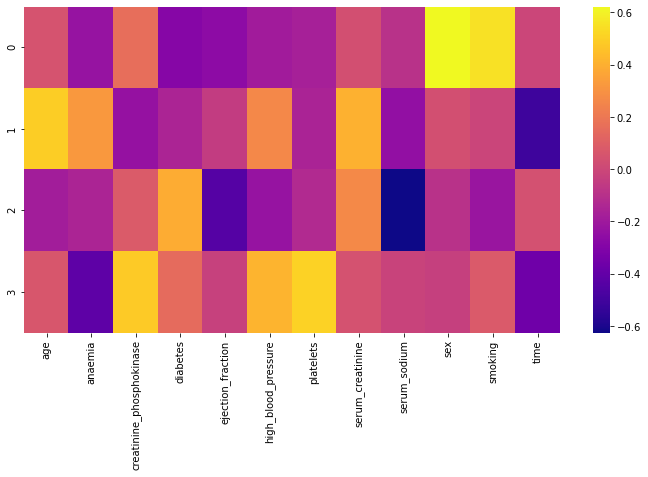

In [21]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [22]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401)
param = grid_search()
print(param)
result = calculate_model(param,X,y)
dict_SV['Pca'] = result
dict_SV


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


{'SVM': [80.29386973180075,
  80.77117148558042,
  72.70205627705627,
  80.29386973180075,
  79.76732175505316,
  85.48631140187794,
  0.01640832742055257],
 'Hypertuned': [82.03563218390805,
  82.91900818121537,
  75.21187793687794,
  82.03563218390805,
  81.71192883754894,
  86.95005029289214,
  0.014444745381673176],
 'Pca': [80.73601532567051,
  81.47661787462233,
  74.41936859436858,
  80.73601532567051,
  80.11939254584928,
  84.8735196389218,
  0.014185336430867513]}

## Feature Importance

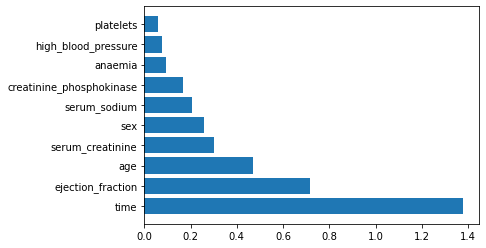

In [23]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

features_names = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine',
      'serum_sodium','sex','smoking', 'time']
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
f_importances(abs(svm.coef_[0]), features_names, top=10)


In [24]:

X = dataset[['time', 'serum_creatinine','ejection_fraction','age','sex','serum_sodium']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['FImp'] = result
dict_SV


{'SVM': [80.29386973180075,
  80.77117148558042,
  72.70205627705627,
  80.29386973180075,
  79.76732175505316,
  85.48631140187794,
  0.01640832742055257],
 'Hypertuned': [82.03563218390805,
  82.91900818121537,
  75.21187793687794,
  82.03563218390805,
  81.71192883754894,
  86.95005029289214,
  0.014444745381673176],
 'Pca': [80.73601532567051,
  81.47661787462233,
  74.41936859436858,
  80.73601532567051,
  80.11939254584928,
  84.8735196389218,
  0.014185336430867513],
 'FImp': [83.37777777777778,
  83.98812243733282,
  77.60040885040885,
  83.37777777777778,
  82.97939115721348,
  88.06433515381099,
  0.01342848300933838]}

## Permutation Importance


In [25]:
#pip install eli5

In [26]:
import eli5
from eli5.sklearn import PermutationImportance
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC(kernel='rbf')
svc.fit(X_train, y_train) 
# create permutation importance object using model
# and fit on test set
perm = PermutationImportance(svc, random_state=1).fit(X_test, y_test)
  
# display weights using PermutationImportance object
eli5.show_weights(perm, feature_names =['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine',
      'serum_sodium','sex','smoking', 'time'])

In [27]:

X = dataset[['time', 'serum_creatinine','ejection_fraction','serum_sodium','age','sex']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['Permutations'] = result
dict_SV


{'SVM': [80.29386973180075,
  80.77117148558042,
  72.70205627705627,
  80.29386973180075,
  79.76732175505316,
  85.48631140187794,
  0.01640832742055257],
 'Hypertuned': [82.03563218390805,
  82.91900818121537,
  75.21187793687794,
  82.03563218390805,
  81.71192883754894,
  86.95005029289214,
  0.014444745381673176],
 'Pca': [80.73601532567051,
  81.47661787462233,
  74.41936859436858,
  80.73601532567051,
  80.11939254584928,
  84.8735196389218,
  0.014185336430867513],
 'FImp': [83.37777777777778,
  83.98812243733282,
  77.60040885040885,
  83.37777777777778,
  82.97939115721348,
  88.06433515381099,
  0.01342848300933838],
 'Permutations': [83.27739463601533,
  84.0958104538112,
  78.09891589891589,
  83.27739463601533,
  82.91195231159618,
  88.15111514884161,
  0.012471493879954021]}

## Sequential Forward Selection

In [28]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=5, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(3, 4, 9, 10, 11)
('3', '4', '9', '10', '11')
CV Score:
0.849290780141844


In [29]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SBS'] = result



In [30]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  SVC()
sfs = SFS(svc, 
          k_features=5, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(0, 4, 5, 9, 11)
('0', '4', '5', '9', '11')
CV Score:
0.849290780141844


In [31]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_SV['SFS'] = result


## RFE

In [32]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

model=RandomForestClassifier()
rfe = RFE(model, n_features_to_select=8, step=1, verbose=2)
rfe = rfe.fit(X_train, y_train)
rfe.support_

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.


array([ True,  True,  True, False,  True, False,  True,  True,  True,
       False, False,  True])

In [33]:
#'age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine', 'serum_sodium','sex','smoking', 'time'
X = dataset[['age','anaemia','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium', 'time']].values

y = dataset.iloc[:, -1].values
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_SV['RFE'] = result


## K-means

In [34]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)


model = KMeans()
#visualizer = KElbowVisualizer(model, k=(1,12)).fit(scaled_features)
#visualizer.show()

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(scaled_features)

In [36]:
y= kmeans.predict(scaled_features)

In [49]:
df = pd.DataFrame(scaled_features , columns= ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine',
      'serum_sodium','sex','smoking', 'time'])
#df['Cluster'] = y
df.head()

age   anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  1.192945 -0.871105                  0.000166 -0.847579          -1.530560   
1 -0.491279 -0.871105                  7.514640 -0.847579          -0.007077   
2  0.350833 -0.871105                 -0.449939 -0.847579          -1.530560   
3 -0.912335  1.147968                 -0.486071 -0.847579          -1.530560   
4  0.350833  1.147968                 -0.435486  1.179830          -1.530560   

   high_blood_pressure     platelets  serum_creatinine  serum_sodium  \
0             1.359272  1.681648e-02          0.490057     -1.504036   
1            -0.735688  7.535660e-09         -0.284552     -0.141976   
2            -0.735688 -1.038073e+00         -0.090900     -1.731046   
3            -0.735688 -5.464741e-01          0.490057      0.085034   
4            -0.735688  6.517986e-01          1.264666     -4.682176   

        sex   smoking      time  
0  0.735688 -0.687682 -1.629502  
1  0.735688 -0.687682 -1.603691  
2  0.735688  1.454161 -1.590785  
3  0.735688 -0.687682 -1.590785  
4 -1.359272 -0.687682 -1.577879

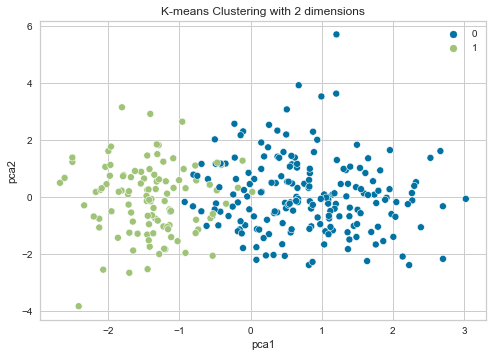

In [50]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
reduced_data = PCA(n_components=2).fit_transform(scaled_features)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=y, data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [51]:
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans'] = result

In [52]:
import shap

In [53]:
import xgboost
model = xgboost.XGBClassifier().fit(df, y)

# compute SHAP values
explainer = shap.Explainer(model, df)
shap_values = explainer(df)

[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


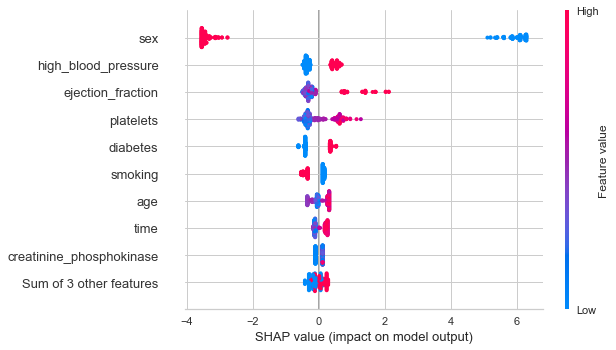

In [54]:
shap.plots.beeswarm(shap_values)

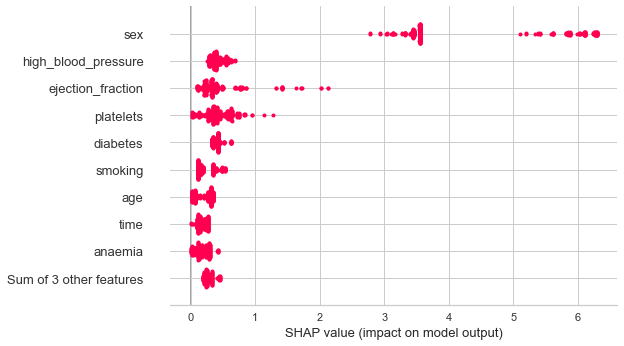

In [55]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

In [60]:
X = dataset[['sex','anaemia','diabetes','high_blood_pressure','ejection_fraction','platelets',
      'smoking','age','time']].values
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
param =grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
result
dict_SV['kmeans+Shap'] = result
result

[99.15172413793105,
 99.20406431796006,
 99.47530663780664,
 99.15172413793105,
 99.14626893781755,
 99.77462457394569,
 0.011055327256520588]

In [61]:
df_dict = pd.DataFrame.from_dict(dict_SV,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM           80.293870  80.771171    72.702056  80.293870  79.767322   
Hypertuned    82.035632  82.919008    75.211878  82.035632  81.711929   
Pca           80.736015  81.476618    74.419369  80.736015  80.119393   
FImp          83.377778  83.988122    77.600409  83.377778  82.979391   
Permutations  83.277395  84.095810    78.098916  83.277395  82.911952   
SBS           82.381226  83.189030    79.171070  82.381226  81.701204   
SFS           83.069732  83.945789    79.174923  83.069732  82.492969   
RFE           81.969732  82.787722    74.037938  81.969732  81.692491   
kmeans        99.331418  99.365814   100.000000  99.331418  99.323584   
kmeans+Shap   99.151724  99.204064    99.475307  99.151724  99.146269   

                    Roc  CPU_time  
SVM           85.486311  0.016408  
Hypertuned    86.950050  0.014445  
Pca           84.873520  0.014185  
FImp          88.064335  0.013428  
Permutations  88.151115  0.012471  
SBS           85.654077  0.014256  
SFS           87.197956  0.014443  
RFE           86.500101  0.016881  
kmeans        99.815698  0.012683  
kmeans+Shap   99.774625  0.011055

In [62]:
#df_dict.to_excel('xl_result/svm_heart2_30.xlsx')

In [7]:
#df_dict =  pd.read_excel('xl_result/svm_heart2_30.xlsx',index_col=0)

In [6]:
# Adding Number of features
df_dict['no_of_features'] = [12,12,'4 components',6,6,5,5,8,12,9]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
SVM           80.293870  80.771171    72.702056  80.293870  79.767322   
Hypertuned    82.035632  82.919008    75.211878  82.035632  81.711929   
Pca           80.736015  81.476618    74.419369  80.736015  80.119393   
FImp          83.377778  83.988122    77.600409  83.377778  82.979391   
Permutations  83.277395  84.095810    78.098916  83.277395  82.911952   
SBS           82.381226  83.189030    79.171070  82.381226  81.701204   
SFS           83.069732  83.945789    79.174923  83.069732  82.492969   
RFE           81.969732  82.787722    74.037938  81.969732  81.692491   
kmeans        99.331418  99.365814   100.000000  99.331418  99.323584   
kmeans+Shap   99.151724  99.204064    99.475307  99.151724  99.146269   

                    Roc  CPU_time no_of_features  
SVM           85.486311  0.016408             12  
Hypertuned    86.950050  0.014445             12  
Pca           84.873520  0.014185   4 components  
FImp          88.064335  0.013428              6  
Permutations  88.151115  0.012471              6  
SBS           85.654077  0.014256              5  
SFS           87.197956  0.014443              5  
RFE           86.500101  0.016881              8  
kmeans        99.815698  0.012683             12  
kmeans+Shap   99.774625  0.011055              9